# Project 1 : One-dimentional diffusion model for CO<sub>2</sub> absorption in the ocean #


Table of contents:

* Definition of functions needed to solve the problems
* Problem 1
* Problem 2
* Testcases


There will be references to spesific equations. Those equation can be found in the project desprition. 


## Definition of functions

This chaper contains all of the essential functions needed to solve the problems. 

The purpose of the functions are descibed short above the cell with the code. Each function is explained in more detail right below the functions decleration.

First, we begin importing needed libraries.

In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

Here we have defined a function that makes the time values and the z-values. 

In [2]:

def t_lst_func(t_0,t_max,i): 
    #function that makes a list of t values from a defined startpoint to a max value. The list has length i.
    
    t_lst=np.linspace(0,t_max,i)
    return t_lst

def z_lst_func(z_0,z_max,n): 
    #function that makes a list of z values from a defined startpoint to a max value. The list has length n=N+1.
    
    z_lst=np.linspace(z_0,z_max,n)
    return z_lst

Here we have defined functions that makes lists of the diffusivity values for the different z values in problem 1 and 2. The K_ shallow_ func solves Eq. (6) in the problem description which we use in problem 1. The K_deep_func solves Eq. (7) in the project description which we use in problem 2. 


In [3]:
#The functions takes in the constants given in the project description and z_lst which is the list of z values

def K_shallow_func(K_0, K_a, K_b, z_a, z_b, L,z_lst):
    # Makes and empty list for the diffusivity values with length N+1.
    # Calculates the diffusivity values for each z by Eq. (6) and appends them in the diffusivity value list.
    # the function returns the list of diffusivity values.
    
    K_lst = np.zeros(len(z_lst)) 
    for i in range(len(z_lst)):
        K_lst[i] = K_0 + K_a*z_lst[i]/(z_a)*np.exp(-z_lst[i]/(z_a)) + K_b*(L-z_lst[i])/(z_b)*np.exp(-(L - z_lst[i])/(z_b))
    return K_lst 


def K_deep_func(K_0, K_1, a, z_0, z_lst):
    # Makes and empty list for the diffusivity values with length N+1.
    # Calculates the diffusivity values for each z by Eq. (7) and appends them in the diffusivity value list.
    # The function returns the list of diffusivity values.
    
    K_lst = np.zeros(len(z_lst)) 
    for i in range(len(z_lst)):
        K_lst[i] = K_1 + (K_0 - K_1)/(1 + np.exp(-a*(z_lst[i] - z_0)))
    return K_lst 


Here we have defined functions that define the constants defined in Eq. (25). We use these constants for calculating the matrices we use for solving our problems. More spesific; they are used in Eq. (24) and Eq. (26). 

In [4]:
def K_marked_func(K_lst):
    # Makes a list K_lst_marked that is one element shorter than the list of diffusivity values, which means N elements.
    # We use a loop to iterate from 1 to N in the diffusivity list.
    # Then the difference between K_(n+1)-K_(n+1) is calculated for each n in the diffusivity list.
    # K_lst_marked is then returned.
    
    K_lst_marked=np.zeros(len(K_lst)-1) 
    for i in range(1,len(K_lst)-1): 
        K_lst_marked[i]=K_lst[i+1]-K_lst[i-1] 
    return K_lst_marked

def alpha_func(delta_t,delta_z):
    #Calculates alpha as defined in Eq. (25)
    
    return delta_t/(2*delta_z**2)

def Gamma_func(alpha,k_w,delta_z,K_lst):
    #Calculates gamma as defined in Eq. (25)
    
    return 2*alpha*k_w*delta_z*(1-((K_lst[1]-K_lst[0])/(2*K_lst[0])))

Here we have defined L and R matrices. First we have functions that define the different diagonals then the matrices_func combines all of these into an L and an R matrix.

In [5]:
def L_main_lst_func(alpha, K_lst, Gamma):
    # This function defines the middle diagonal in the L_matrix as defined in Eq. (26a).
    # The diagonal is made as a list. First we define the list, which has N+1 elements.
    # The function takes in alpha, gamma and the list of diffusivity values as parameters. 
    # First we define the first element, which is a bit different from the rest.
    # Afterwards a for-loop is used to define the rest of the elements in the list.
    # Eventually, the list is returned.
    
    L_main_lst = np.zeros(len(K_lst))
    
    L_main_lst[0] = 1+2*alpha*K_lst[0]+Gamma
    
    for i in range(1, len(K_lst)):          #Starts the for loop at 1 since the first element is already added
        L_main_lst[i] = 1+2*alpha*K_lst[i]
    
    return L_main_lst


def L_upper_lst_func(alpha, K_lst, K_marked_lst):
    # This function defines the diagonal above the middle diagonal in the L_matrix as defined in Eq. (26a). 
    # The diagonal is made as a list. First we define the list, which has N elements.
    # The function takes in alpha, K_marked_lst and the list of diffusivity values as parameters. 
    # First we define the first element, which is a bit different from the rest.
    # Afterwards a for-loop is used to define the rest of the elements in the list.
    # Eventually, the list is returned.
    
    L_upper_lst = np.zeros(len(K_lst)-1)
    
    L_upper_lst[0] = -2*alpha*K_lst[0]
    
    for i in range(1, len(K_lst)-1):        #Starts the for loop at 1 since the first element is already added
        L_upper_lst[i] = alpha*(-(1/4)*K_marked_lst[i]-K_lst[i])
    
    return L_upper_lst


def L_lower_lst_func(alpha, K_lst, K_marked_lst):
    # This function defines the diagonal below the middle diagonal in the L_matrix as defined in Eq. (26a). 
    # The diagonal is made as a list. First we define the list, which has N elements.
    # The function takes in alpha, K_marked_lst and the list of diffusivity values as parameters. 
    # We use a for-loop to define all the elements in the list, except the last one, due to that is a bit different fr0m the others. 
    # After the for-loop, the last element is defined. 
    # Eventually, the list is returned.
    
    L_lower_lst = np.zeros(len(K_lst)-1)
    
    for i in range(0, len(K_lst)-2): 
        L_lower_lst[i] = alpha*((1/4)*K_marked_lst[i+1]-K_lst[i+1])
        
    L_lower_lst[-1] = -2*alpha*K_lst[-1]  #L_lower_lst[-1] = L_lower_lst[N-1]
    
    return L_lower_lst
    
    
    
def R_main_lst_func(alpha, K_lst, Gamma):
    # This function defines the middle diagonal in the R_matrix as defined in Eq. (26b).
    # The diagonal is made as a list. First we define the list, which has N+1 elements.
    # The function takes in alpha, gamma and the list of diffusivity values as parameters. 
    # First we define the first element, which is a bit different fr0m the rest.
    # Afterwards a for-loop is used to define the rest of the elements in the list.
    # Eventually, the list is returned.
    
    R_main_lst = np.zeros(len(K_lst))
    
    R_main_lst[0] = 1-2*alpha*K_lst[0]-Gamma
    
    for i in range(1, len(K_lst)):  #Starts the for loop at 1 since the first element is already added
        R_main_lst[i] = 1-2*alpha*K_lst[i]
    
    return R_main_lst



def R_upper_lst_func(alpha, K_lst, K_marked_lst):
    # This function defines the diagonal above the middle diagonal in the R_matrix as defined in Eq. (26b). 
    # The diagonal is made as a list. So first we define the list, which has N elements.
    # The function takes in alpha, K_marked_lst and the list of diffusivity values as parameters. 
    # First we define the first element, which is a bit different from the rest.
    # Afterwards a for-loop is used to define the rest of the elements in the list.
    # Eventually, the list is returned.
    
    R_upper_lst = np.zeros(len(K_lst)-1)
    
    R_upper_lst[0] = 2*alpha*K_lst[0]
    
    for i in range(1, len(K_lst)-1): #Starts the for loop at 1 since the first element is already added
        R_upper_lst[i] = alpha*((1/4)*K_marked_lst[i]+K_lst[i])
    
    return R_upper_lst


def R_lower_lst_func(alpha, K_lst, K_marked_lst):
    # This function defines the diagonal below the middle diagonal in the R_matrix as defined in Eq. (26b). 
    # The diagonal is made as a list. So first we define the list, which has N elements.
    # The function takes in alpha, K_marked_lst and the list of diffusivity values as parameters. 
    # We use a for-loop to define all the elements in the list, except the last one, due to that is a bit different from the others. 
    # After the for-loop, the last element is defined. 
    # Eventually, the list is returned.
    
    R_lower_lst = np.zeros(len(K_lst)-1)
    
    for i in range(0, len(K_lst)-2):
        R_lower_lst[i] = alpha*(-(1/4)*K_marked_lst[i+1]+K_lst[i+1])
        
    R_lower_lst[-1] = 2*alpha*K_lst[-1]  #L_lower_lst[-1] = L_lower_lst[N-1]
    
    return R_lower_lst


def matrices_func(alpha, K_lst, K_marked_lst, Gamma):
    # This function makes the L and R matrices and returns them.
    # The function takes in the constants alpha and gamma, and the list for the K marked values and the diffusivity values. 
    # First it calls on the functions that make the diagonals for the matrices.
    # Then it creates the matrices by using the built in the diags functions from the scipy library.
    
    # Creating diagonals for L
    L_main  = L_main_lst_func(alpha, K_lst, Gamma)
    L_upper = L_upper_lst_func(alpha, K_lst, K_marked_lst)
    L_lower = L_lower_lst_func(alpha, K_lst, K_marked_lst)
    
    # Creating diagonals for R
    R_main  = R_main_lst_func(alpha, K_lst, Gamma)
    R_upper = R_upper_lst_func(alpha, K_lst, K_marked_lst)
    R_lower = R_lower_lst_func(alpha, K_lst, K_marked_lst)

    # Creating sparse matrices
    # Give a list of the diagonals, and a corresponding list of offsets
    # offset of 0 is the main diagonal, offset -1 is the first lower diagonal, etc.
    # (scipy.sparse.diags was imported above)
    L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])
    R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])
    
    return L, R


Here we define S matrices. The S matrices contains the equilibrium consentrations. S_shallow_func is for problem 1 where the equlibrium is constant, and S_deep_func is for problem 2 where the equilibrium concentration changes. 

In [6]:
def S_shallow_func(Gamma,H,p_CO2,n,i):
    # The function takes in the constants gamma, H and p_co2, in addition to n and i.
    # H*p_CO2 is the equlibrium conventration. 
    # n = N+1 and is in our case the lenght of the z list. i is the number of time steps and the lengt of the t list.
    # First we make a matrix with i columns and n rows. 
    # Each columns represents one timestep and in each column all the elements excpet the first one is zero.
    # The first element in each column is responsible for the flux at the surface.
    # The for-loop appends the value given in Eq. (24) in the project description in the first element in each column 
    # and then appends the columns in the matrix.
    # Finally, the matrix is returned.
    
    rows, cols = (n, i) 
    S_matrix=[] 
    for i in range(cols): 
        col =np.zeros(n)
        col[0]= 2*Gamma*H*p_CO2
        S_matrix.append(col)
    return S_matrix


def S_deep_func(Gamma,H,p_CO2,i,n): 
    # The function takes in the constants gamma, H and p_co2, in addition to n and i.
    # H*p_CO2 is the equlibrium conventration at the startingtime.
    # n is the N+1 and is the lenght of for example the z list. i is the number of time steps and the lengt of the t list.
    # First we make a matrix with i columns and n rows. 
    # Each columns is for one timestep and in each column all the elements excpet the first is zero.
    # The first element is responsible for the flux at the surface.
    # The for-loop appends the value given in Eq. (24) in the project description in the first element in each column.
    # Due to that the value changes with the time, we have added a term that increases the equilibrium consentration by 2.3 ppm per year
    # The columns are then appended in the matrix.
    # Finally, the matrix is returned.
    
    rows, cols = (n, i) 
    S_matrix=[] 
    for j in range(cols): 
        col =np.zeros(n)
        col[0]= 2*Gamma*H*(p_CO2+2.3*(j*1800)/(3600*24*365)*10**(-6))
        S_matrix.append(col)  
        
    return S_matrix


We were given the block of code below, so we have only implemented it. 
This solves the matrix equation given as Eq. (28) in the project description by using and Tri-Diagonal Matrix Algorithm (TDMA).

In [7]:
# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

Here we solve the matrix equation given in Eq. (27) and Eq. (28) in the project description.

In [8]:
def C_solver(R,C_0,L,S_matrix):
    # The function takes in the start concentration of DIC in the water C_0 and the L,R and S matrices.
    # First we define a matrix that will hold the different concentration of DIC for each timstep
    # Then the initial concentration is appended. 
    # The for-loop makes V which is defined in Eq. (27) in the prject description 
    # and then solves the matrix equation given in Eq. (28).
    # The for loop does this for each timestep.
    # Then the matrix is returned. 
    
    
    C_matrix = []
    C_matrix.append(C_0)
    
    for i in range(1,len(S_matrix)-1):
        V=R.dot(C_matrix[i-1])+1/2*(S_matrix[i-1]+S_matrix[i])
        C=tdma(L,V)
        C_matrix.append(C)  
        
    return C_matrix

## Problem 1: Response to changing $CO_2$ concentration in shallow areas ##

In this problem, we will consider a relatively shallow area, such as the Norwegian Continental shelf, and study approximately how long it takes for the water at the sea floor to respond to a change in the atmospheric concentration of $CO_2$. In other words, we want to find out if the concentration of DIC in the water “lags behind” the changes in the atmosphere, or if the whole water column is more or less at the equilibrium concentration predicted by the  atmospheric $CO_2$.


#### 1a)
The shallow area we will consider has a depth of L = 100 m. We will therfore use the function K_shallow_func to describe the diffusivity at different depths, which solves for Eq. (6) in the project desctiption. Futhermore, we will set the concentration of $CO_2$ in the atmosphere to 415 ppm, which is about what it is at this present time. Because of the problem description, this consentration of $CO_2$ will of course not change, and we therefore have to use the function S_shallow_func to describe the flux of $CO_2$ at the surface. To be able to easily study how water at different depths respond to a change in the atmospheric concentration of $CO_2$, the initial concentration of DIC in the water is set to zero. Lastly, the simulation runs for 180 days.

In this code block constants used for problem 1 are defined. 
The unit and where we have the values from is commented.

In [9]:
# These constant are given in Eq. (6) in the project description and are used to calculate the diffusivity in problem 1.
K_0_shallow =10**(-3)      # [m^2/s]
K_a_shallow = 2*10**(-2)   # [m^2/s]
K_b_shallow = 5*10**(-2)   # [m^2/s]
z_a_shallow = 7            # [m]
z_b_shallow = 10           # [m]

# The depth of the water in problem 1. It is given in meters.
L_shallow_const = 100       # [m]

# This is our chosen timestep. It is given in seconds.
delta_t = 1800              # [s]

# This constant is given below Eq. (5) in the project description. 
# It describes the rate of mass transfer at the surface of the ocean.
# The unit is m/s
k_w = 6.97*10**(-5)         # [m/s]

# This constant is given below Eq. (4) in the project description. H is a proportionality constanst.
# The unit is mol m^(-3) atm (-1)
H = 5060                    # [m^(-3) atm (-1)]

# This constant is given above Eq. (4) in the project description. p_CO2 is the partial pressure of CO2 in the atmosphere.
# The unit is atm
p_CO2=415*10**(-6)          # [atm]

# This is the maximum time we are running the simulation for. Here it is 180 days. The number of seconds 
# in an hour has been multiplied with number of hours in a day and then again multiplied with a factor 180,
# representing the number of seconds in 180 days in total.
# The unit is seconds
t_max=3600*24*180           # [s]

# This is the intitial time and depth. Both is set to zero
t_0 = 0                     # [s]
z_0 = 0                     # [m]

# i is the number of time steps 
i = int(t_max/delta_t)

# n is the number z values. n equals N+1, where N is 1000
n = 1001

Here we define a function that makes a list of the initialconcentration of DIC in the water. 

In [10]:
def C_0_func(z_lst):
    # This function takes in the list of z values and returns a list of the initial concentration of DIC for all the z values.
    # The C_0_lst har N+1 elements
    # In problem 1 the initial concentration of DIC is 0 for all dephts/z-values.
    
    C_0_lst=np.zeros(len(z_lst))
    return C_0_lst

Here we call upon the already defined functions that are relevant for problem 1 and store the return values of each function as variables. 

In [11]:
# Makes a list of z values from a defined startpoint to a max value. The list has length N+1.
# The z values represents the different depths in the water.
z_lst = z_lst_func(z_0,L_shallow_const,n)

# Finds the difference between one z value and the next. This value is constant for all z values.
delta_z = z_lst[1]-z_lst[0]


t_lst = t_lst_func(t_0, t_max, i)

C_0_lst=C_0_func(z_lst)

K_shallow_lst = K_shallow_func(K_0_shallow, K_a_shallow, K_b_shallow, z_a_shallow, z_b_shallow, L_shallow_const, z_lst)
K_shallow_marked_lst = K_marked_func(K_shallow_lst)


alpha = alpha_func(delta_t,delta_z)
Gamma_shallow = Gamma_func(alpha,k_w,delta_z,K_shallow_lst)


S_shallow_lst = S_shallow_func(Gamma_shallow,H,p_CO2,n,i)
L_shallow, R_shallow = matrices_func(alpha, K_shallow_lst, K_shallow_marked_lst, Gamma_shallow)

C_matrix_shallow = C_solver(R_shallow, C_0_lst, L_shallow, S_shallow_lst)

### Plotting of problem 1

#### 1b)

Here we plot the minimum and maximum concentration of DIC as a function of time. We also plot the equlibrium concentration

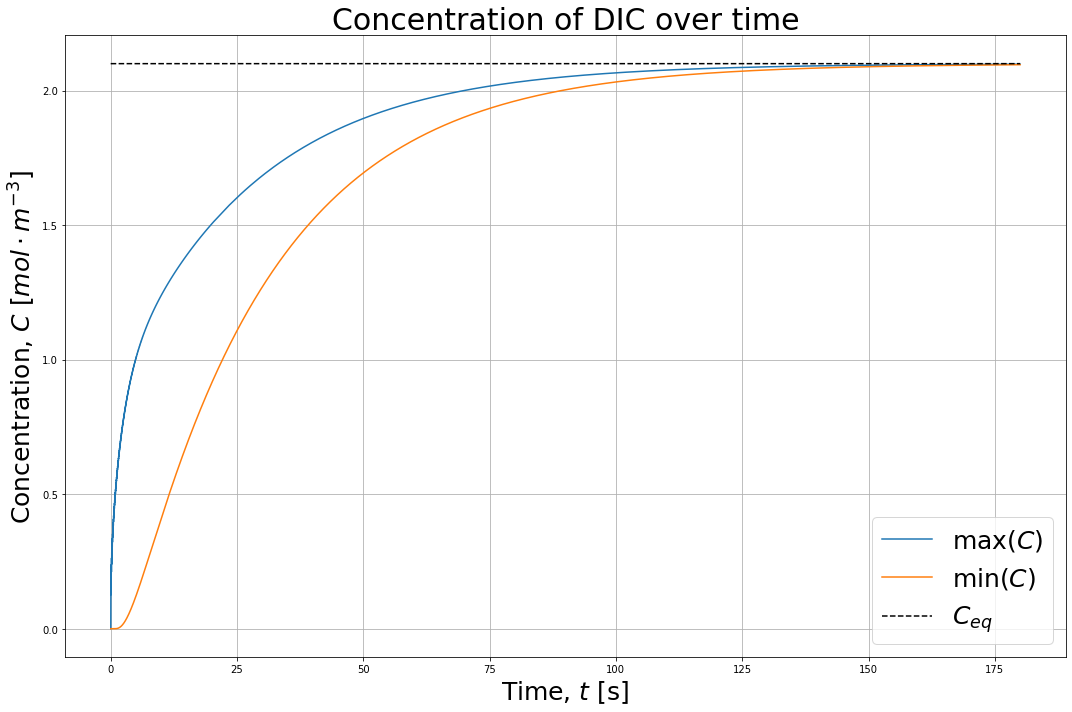

In [12]:
# Makes a figure and sets the size of the figure
plt.figure(2, figsize = [15,10])

# Plots the max concentration of DIC as a function of time
plt.plot(t_lst[1:] / (24*60*60), np.amax(C_matrix_shallow, axis = 1), label = '$\max(C)$')
# Plots the min concentration of DIC as a function of time
plt.plot(t_lst[1:] / (24*60*60), np.amin(C_matrix_shallow, axis = 1), label = '$\min(C)$')
# Plots the equilibrium concentration as a function of time
plt.plot(t_lst / (24*60*60), H*p_CO2*np.ones_like(t_lst), '--', c = 'k', label = '$C_{eq}$')

# Gives us a box in the plot that defines the different functions and sets the size of this box
plt.legend(prop = {'size':25})
# Gives the plot a title and gives the axes titles
plt.title("Concentration of DIC over time", fontsize = 30)
plt.xlabel("Time, $t$ [s]", fontsize = 25)
plt.ylabel("Concentration, $C$ [$mol\cdot m^{-3}$]", fontsize = 25)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()

The plot above shows that both the maximum and minimum concentration of DIC  in the water column approaches the equlibrium concentration, the black dotet line, within the 180 days. Moreover, the maximum concentration approaches the equlibrium concentration faster than the minimum concentration, as expected. In addition, we also notice that the consentration increases faster in the beginning, where the difference between the concentration of DIC and the equilibrium concentration $C_{eq}$ is largest, causing a larger positive flux into the water and again a larger consentration of DIC, than at the end. This is in compliance with Eq.(3).


#### 1c)

Here we plot the concentration of DIC as a function of depth for different times

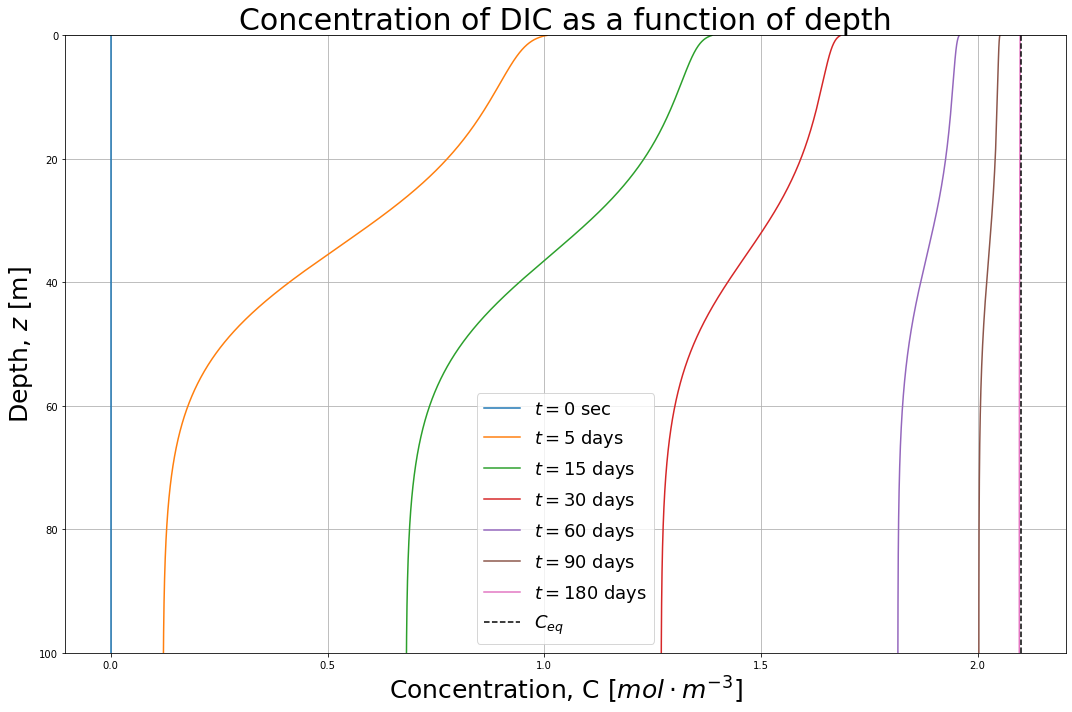

In [13]:
# Makes a figure and sets the size of the figure
plt.figure(1, figsize = [15,10])

# Here we plot the concentration of DIC against depth for different times
plt.plot(C_matrix_shallow[0], z_lst,label = "$t=0$ sec")
plt.plot(C_matrix_shallow[int(np.shape(C_matrix_shallow)[0]/36)], z_lst, label="$t=5$ days")
plt.plot(C_matrix_shallow[int(np.shape(C_matrix_shallow)[0]/12)], z_lst, label="$t=15$ days")
plt.plot(C_matrix_shallow[int(np.shape(C_matrix_shallow)[0]/6)], z_lst, label="$t=30$ days")
plt.plot(C_matrix_shallow[int(np.shape(C_matrix_shallow)[0]/3)], z_lst, label="$t=60$ days")
plt.plot(C_matrix_shallow[int(np.shape(C_matrix_shallow)[0]/2)], z_lst, label="$t=90$ days")
plt.plot(C_matrix_shallow[-1], z_lst, label = "$t=180$ days")

#Plots the equlibrium concentration as a black dotet line
plt.axvline(x=H*p_CO2,ls='--', c = 'k', label = '$C_{eq}$')
#Gives us a box in the plot that defines the different functions and sets the size of this box
plt.legend(prop = {'size':18})
# Gives the plot a title and gives the axes titles
plt.title("Concentration of DIC as a function of depth", fontsize = 30)
plt.xlabel("Concentration, C [$mol\cdot m^{-3}$]", fontsize = 25)
plt.ylabel("Depth, $z$ [m]", fontsize = 25)
# Sets the span of the y axis
plt.ylim(100, 0)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()



In the plot above we can see that the concentration at time $t=0$ is zero which was given in the problem.

As mentioned in the previous task, the difference between the concentration of DIC and the equilibrium concentration $C_{eq}$ is large in the beginning, causing a large positive flux of DIC into the water according to Eq.(3). Consequently, the mass transfer of DIC at the surface will be faster/greater than the diffusion. As a result, the upper levels of the ocean will have a higher consentration of DIC than lower levels. The consentration of DIC when $t=5$ days, $t=15$ days and $t=30$ days illustrates this.

As more mass is being transported into the ocean and the diffusion transports it to lower levels the ratio between the mass transfer and diffusion vil decrease. For this reason, the consentration of DIC across the water column will more or less be constant. The consentration og DIC when $t=60$ days, $t=90$ days and $t=180$ days illustrates this. In other words, the consentration for all depths will approch the equilibrium concentration. This will show as vertical graph in the plot, and is here illustrated as a black dottet line. 

We can see that for $t=180$ days the concentration in the ocean is close to the equilibrium concentration for all depths which means that flux at the ocean surface is next to zero. We can see from the plot that it takes approximatly 180 days for changes at the surface on the ocean to reach the bottom.

#### 1d) ####
Considering that the level of $CO_2$ in the atmosphere changes only slowly from year to year would you say that the water at 100 m depth is “in sync” with the changes in the atmosphere?

##### Answer ####

In this case where the difference between the initial concentrations in the ocean and air was great we would say that the changes in the ocean is not in sync, but if the initial concentration difference is smaller then it could be said that the changes are in sync. If the changes in the atmosphere is small the changes in the ocean would be relativley in sync.

#### Extra ####

Here we plot the diffusivity as a function of depth.

Notice that this is not a part of the problem description but we found it useful in interpreting the plots above.

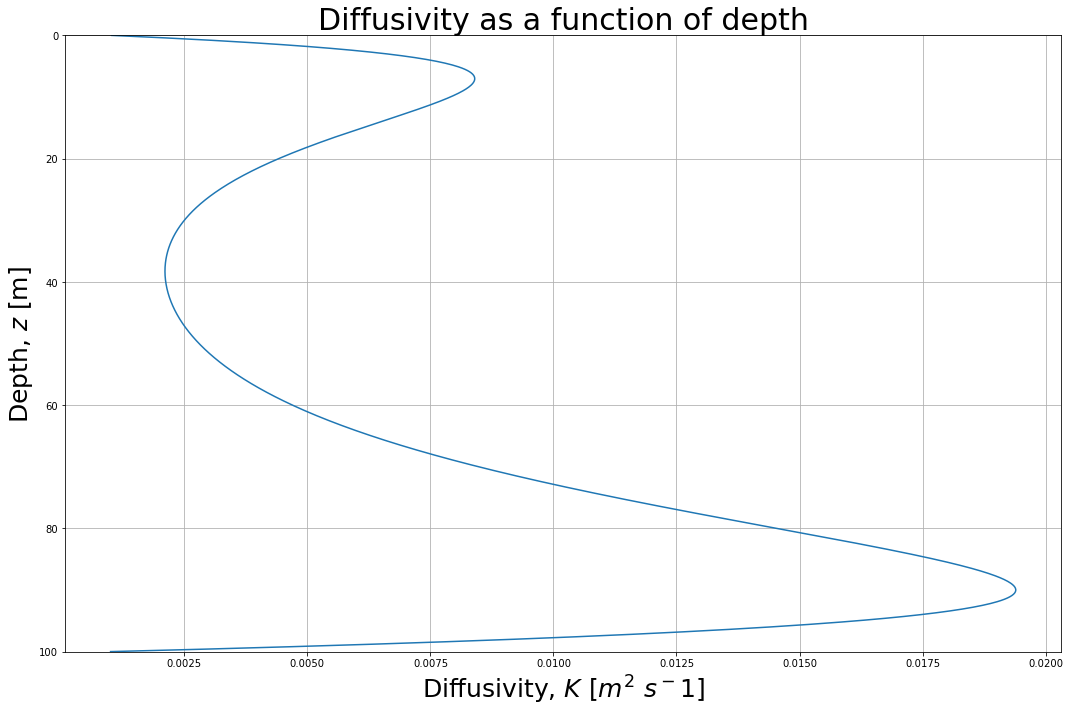

In [14]:
# Makes a figure and sets the size of the figure
plt.figure(3, figsize = [15,10])

#Plots the diffusivity as a function of z
plt.plot(K_shallow_lst, z_lst)


# Gives the plot a title and gives the axes titles
plt.title("Diffusivity as a function of depth", fontsize = 30)
plt.xlabel("Diffusivity, $K$ [$m^2$ $s^-1$]", fontsize = 25 )
plt.ylabel("Depth, $z$ [m]", fontsize = 25)
# Sets the span of the y axis
plt.ylim(100, 0)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()

As we can see from the plot, the diffusivity is low around 20 - 60 meters depth, where the minima is around 40 meters. This low diffusivity explains why the concentration of DIC in the water, plotted in task 1c), “lags behind” the changes in the atmosphere. Similar, the diffusivity is very high around 70 - 95 meters depth, again, explaining why the concentration of DIC in the water in this particular interval is more or less a straight and vertically line. 

## Problem 2 ##

In this problem, we will consider an increasing concentration of atmospheric $CO_2$, and study how the consentration of DIC at different depths in the ocean changes over time. From here we will study how the total mass of DIC in the global oceans increases over time. Subsequently, we will try to estimate the amount of $CO_2$ absorbed by the ocean on an annual basis.




#### 2a)
Due to that the average depth of the oceans as a whole is approximately 4000 m, we will consider a water of this depth. We will therfore use the function K_deep_func to describe the diffusivity at different depths, which solves for Eq. (6) in the project desctiption. Futhermore, we will set the initial concentration of $CO_2$ in the atmosphere to 415 ppm. The initial consentration of DIC in the ocean is constant and in equilibrium with the atmospheric concentration of $CO_2$. We will use that the consentration of atmoshperic $CO_2$ increases by 2.3 ppm/year. Consequently, we will be needing the function S_deep_func to describe the flux of $CO_2$ at the surface of the ocean.

In this code block constants used for problem 2 are defined. 
The unit and where we have the values from is commented.

In [15]:
# These constant are given in Eq. (7) in the project description and are used to calculate the diffusivity in problem 2.
K_0_deep = 10**(-4)  # [m^2/s]
K_1_deep = 10**(-2)  # [m^2/s]
a = 0.5              # [m^(-1)]
z_0_deep = 100       # [m]

# The depth of the water in problem 2. It is given in meters.
L_deep_const = 4000  # [m]

# This is our chosen timestep. It is given in seconds.
delta_t = 1800       # [s]

# This constant is given below Eq. (5) in the project description. 
# It describes the rate of mass transfer at the surface of the ocean.
# The unit is m/s
k_w=6.97*10**(-5)    # [m/s]

# This constant is given below Eq. (4) in the project description. H is a proportionality constanst.
# The unit is mol m^(-3) atm^(-1)
H=5060               # [m^(-3) atm^(-1)]

# This constant is given above Eq. (4) in the project description. p_CO2 is the partial pressure of CO2 in the atmosphere.
# The unit is atm
p_CO2=415*10**(-6)   # [atm]

# This is the maximum time we are running the simulation for. Here it is 10 years. The number of seconds 
# in an hour has been multiplied with number of hours in a day with the number of days in a year and then 
# again multiplied with a factor 10, representing the number of seconds in 10 years in total.
# The unit is seconds.
t_max=3600*24*365*10 #[s] 

# This is the intitial time and depth. Both is set to zero. The units are respectively seconds and meters. 
t_0 = 0              # [s]
z_0 = 0              # [m]

# i is the number of time steps 
i = int(t_max/delta_t)

# n is the number z values
n = 1001

Here we define a few functions that we need to solve problem 2. C_0_func_2 gives us a list of the initial concentration of DIC in a column. Mass_lst_func calculates the mass of DIC by using simpsons method. Absorbed_mass_func calculates the average absorbed mass over 10 years.

In [16]:
def C_0_func_2(z_lst):
    # The function takes in z_lst and returns a list of the initial concentration of DIC.
    # The C_0_lst has lengt N+1
    # In problem 2 the initial concentration of DIC is given as the equlibrium concentration for time 0, and it is constant.
    
    C_0_lst = np.ones(len(z_lst))*H*p_CO2
    return C_0_lst

def mass_lst_func(C_matrix, z_lst):
    # The function takes in z_lst and C_matrix and returns a list, mass, of length i-1.
    # The mass for each timestep is calculated using the simpsons method.
    # mass is a list which contains the calculated mass of DIC for each timstep.
    # 
    
    mass = simps(C_matrix, x = z_lst, axis=1)*360*10**(12)*12
    return mass

def absorbed_mass_func(mass_lst_deep):
    # The function takes in a list of masses for each timestep and returns the value for the average absorbed mass in a year
    # The average is calculated by taking the last mass minus the first and dividing by 10 which is the number of years.
    
    average_absorbed_mass = (mass_lst_deep[-1] - mass_lst_deep[0])/(10)
    return average_absorbed_mass

Here we call upon the already defined functions that are relevant for problem 2 and store the return values of each function as variables. 

In [17]:
# Makes a list of z values from a defined startpoint to a max value.The list has length N+1.
# The z values are for deepth in the ocean.
z_lst = z_lst_func(z_0,L_deep_const,n)

# Finds the difference between one z value and the next. This value is constant for all z values.
delta_z = z_lst[1]-z_lst[0]

t_lst = t_lst_func(t_0, t_max, i)

C_0_lst_deep = C_0_func_2(z_lst)


K_deep_lst = K_deep_func(K_0_deep, K_1_deep, a, z_0_deep, z_lst)
K_deep_marked_lst = K_marked_func(K_deep_lst)

alpha = alpha_func(delta_t, delta_z)

Gamma_deep = Gamma_func(alpha, k_w, delta_z, K_deep_lst)

S_deep_lst = S_deep_func(Gamma_deep, H, p_CO2, i, n)

L_deep, R_deep = matrices_func(alpha, K_deep_lst, K_deep_marked_lst, Gamma_deep)

C_matrix_deep = C_solver(R_deep, C_0_lst_deep, L_deep, S_deep_lst)


mass_lst_deep = mass_lst_func(C_matrix_deep, z_lst)

average_absorbed_mass = absorbed_mass_func(mass_lst_deep)

### Plotting Problem 2

#### 2b)
Here we plot the concentration of DIC as a function of depth for different times.

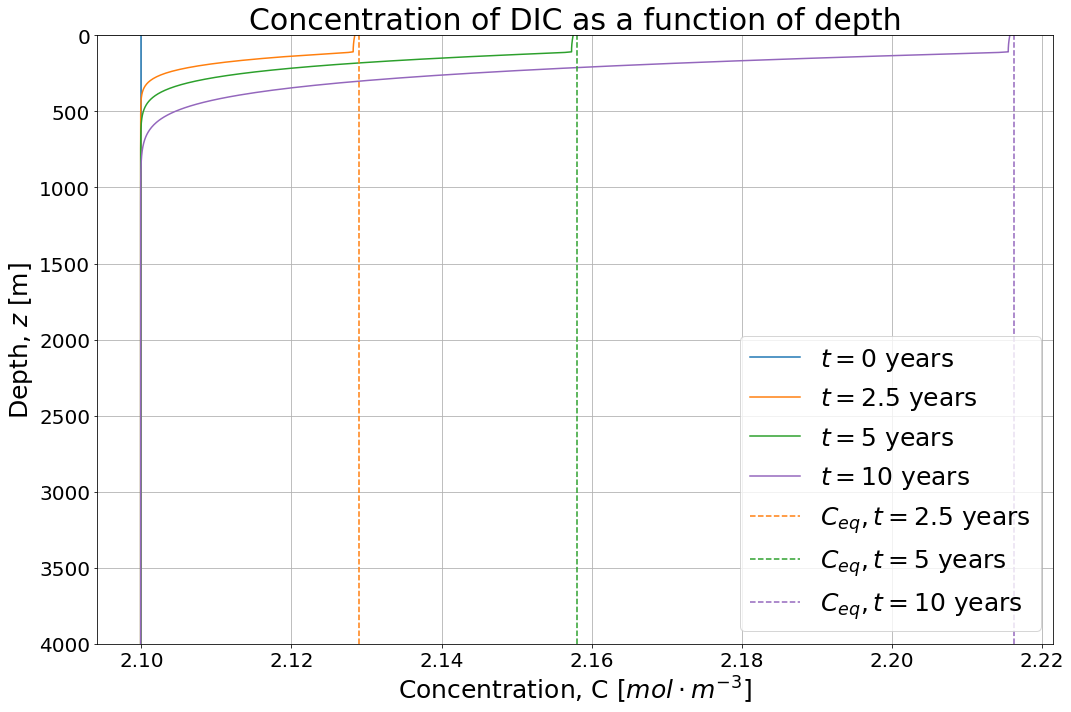

In [18]:
# Makes a figure and sets the size of the figure
plt.figure(4, figsize = [15,10])

# Here we plot the concentration of DIC against depth for different times
plt.plot(C_matrix_deep[0], z_lst, label="$t=0$ years")
plt.plot(C_matrix_deep[int(np.shape(C_matrix_deep)[0]/4)], z_lst,label="$t=2.5$ years")
plt.plot(C_matrix_deep[int(np.shape(C_matrix_deep)[0]/2)], z_lst,label="$t=5$ years")
plt.plot(C_matrix_deep[-1], z_lst, label = "$t=10$ years",c = 'C4')

#Plots the equlibrium concentration as a black dotet line
plt.axvline(x=H*(p_CO2+2.3*10**(-6)*2.5),ls='--', c='C1', label='$C_{eq},t=2.5$ years')
plt.axvline(x=H*(p_CO2+2.3*10**(-6)*5),ls='--', c = 'C2', label = '$C_{eq},t=5$ years')
plt.axvline(x=H*(p_CO2+2.3*10**(-6)*10),ls='--', c = 'C4', label = '$C_{eq},t=10$ years')
            
#Gives us a box in the plot that defines the different functions and sets the size of this box
plt.legend(prop = {'size':25})
# Gives the plot a title and gives the axes titles
plt.title("Concentration of DIC as a function of depth", fontsize = 30)
plt.xlabel("Concentration, C [$mol\cdot m^{-3}$]", fontsize = 25)
plt.ylabel("Depth, $z$ [m]", fontsize = 25)
# Sets the font sozeof the x and y axes
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# Sets the span of the y axis
plt.ylim(4000, 0)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()


In the plot we can see that the changes in the mixed layer is a lot faster than changes in the deep ocean. The graphs in the plot have an almost straight angle at a depth of 100 meters where the mixed layer and deep ocean meet. This is a result of the big difference in diffusivity in the two layers (see under probelm 2 Extra). During the 10 years period, the DIC is barely transported into the deep ocean. The changes in the deep ocean and the atmosphere is clearly not in sync. This is in contrats to the changes in the mixed layer which is quite in sync with the changes in the atmosphere.

#### 2c)
Here we plot mass as a function of time

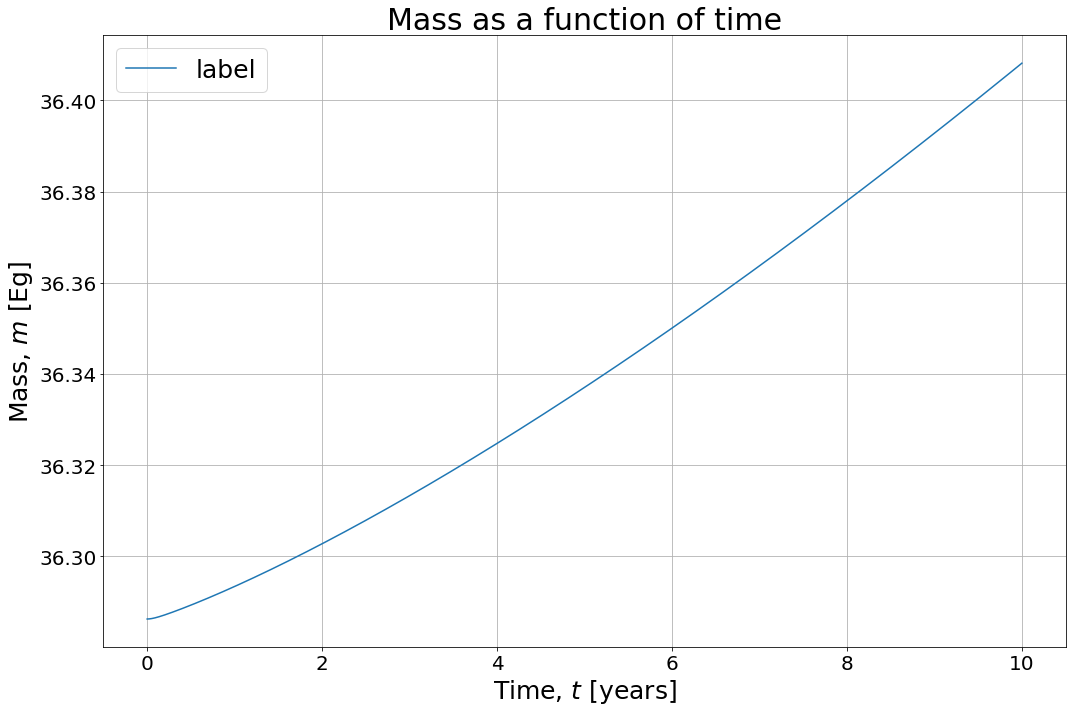

In [19]:
# Makes a figure and sets the size of the figure
plt.figure(5, figsize = [15,10])

# Here we plot the concentration of mass ass a function of time
plt.plot(t_lst[:-1]/(3600*24*365), mass_lst_deep/(10**18), label = "label")  #konstant burde være oppe med resten av konstene
plt.legend(prop={'size':25})

#Gives us a box in the plot that defines the different functions and sets the size of this box
plt.legend(prop = {'size':25})
# Gives the plot a title and gives the axes titles
plt.title("Mass as a function of time", fontsize = 30)
plt.xlabel("Time, $t$ [years]", fontsize = 25)
plt.ylabel("Mass, $m$ [Eg]", fontsize = 25)
# Sets the font sozeof the x and y axes
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()


In this plot we can see that the mass of DIC in the ocean increases next to linearly. We plottet the mass in Eg which is $10^{-18}g$.

#### 2d)
Find the amount of $CO_2$ absorbed by the entire global ocean in a year by looking at the mass in the
water column at the start of the simulation, compared to the mass at the end of the simulation, and
take the average over the 10 years.

In [20]:
print('Total mass absorbed in a year: ',"{:e}".format(average_absorbed_mass), "g")

Total mass absorbed in a year:  1.218941e+16 g


#### 2e)
Here we will interpret the answer we found in task 2d) and compare it to the value $2.5*10^{15}$ in light of the simplifications we have done in this model. 

We have assumed that the ocean can be described as a one-dimensional model which is a great simplification. In reality the ocean is of course not a onedimensional model, and the simplification ignores several processes that will effect the amount of $CO_2$ the ocean can absorb. First, the model does not take temperature differences between different regions into accont. This means that the model do not take into consideration that $CO_2$s ability to dissove in water is greater at lower temperartures than at higher temperartures. Due to these temperature differences, as well as differences in wind and salinity (and earth rotation), the ocean transports warmer water to colder areas and vice verca, and the water will again have different ability to absorb $CO_2$, depending on the temperature where the water is transported. Moreover, the model assumes that the partial pressure of $CO_2$ is constant for all areas, which is not the case in reality. In despite of ignoring these prosesses, it doesnt necessarily make a huge impact to our results, owing to that we integrate over large areas and areas with larger absorption of $CO_2$ will be canselled out by areas with lower absorpsion of $CO_2$. 

Futhermore, we have also assumed a constant depth of 4000 meters. If we look at the plot of diffusivity as a function of depth (below, under extra), it doesnt really matter if the ocean floor is 5000 meters or 3000 meter somewhere, as long as the diffusivity is as low as it is for the deep ocean. This can be illustrated by looking at the consentration as a function of depth in task 2b) where the consentration of DIC for depths below 1000 meters is more or less det same for all of the times. 

In addition, we have also assumed that everything is constant for all times. For example, the weather and klimate is constant during the period of 10 years. Futhermore, we have also assumed that the consentration of atmospheric $CO_2$ increases by 2.3 ppm/year, and this isnt necessarily totaly reasonable. From Fig. (3) in the project description, 2.3 ppm/year is just the current growth rate, but the trend in $CO_2$ in the atmosphere is exponential. If the trend were to continue, this growth rate would increase over time, leaving us with a higher result for task 2d) if this were to be taken into consideration in our model.

Moreover, we know that living organisms in the ocean produce $CO_2$. Even though $CO_2$ do not count for “anthropogenic" $CO_2$, is still "takes up the place" to “anthropogenic" $CO_2$, leaving us with a lower result for task 2d) if this were to be taken into consideration in our model.

To conclude, as discussed, there are severeal prosesses this model ignores. However, our result was only one order of magnitude higher than the result given in the project description, which were $2.56\cdot 10^{15}$ g. This is a quite good result compared to the simplicity of our model. We have ignored several mechanisms that impact the absorption of $CO_2$ so one order of magnitude in difference is only to be expected. The reason for a this good result might be that we integrate over large areas and that the different prosesses we ignore cancels each other out. On the other hand, we might have just been lucky, beacuse by simplifying the model this much, the model leaves a great uncertainty to the result. 

#### Extras ####
Here we plot the diffusivity as a function of depth.

Notice that this is not a part of the problem description but we found it useful in interpreting the plots above.


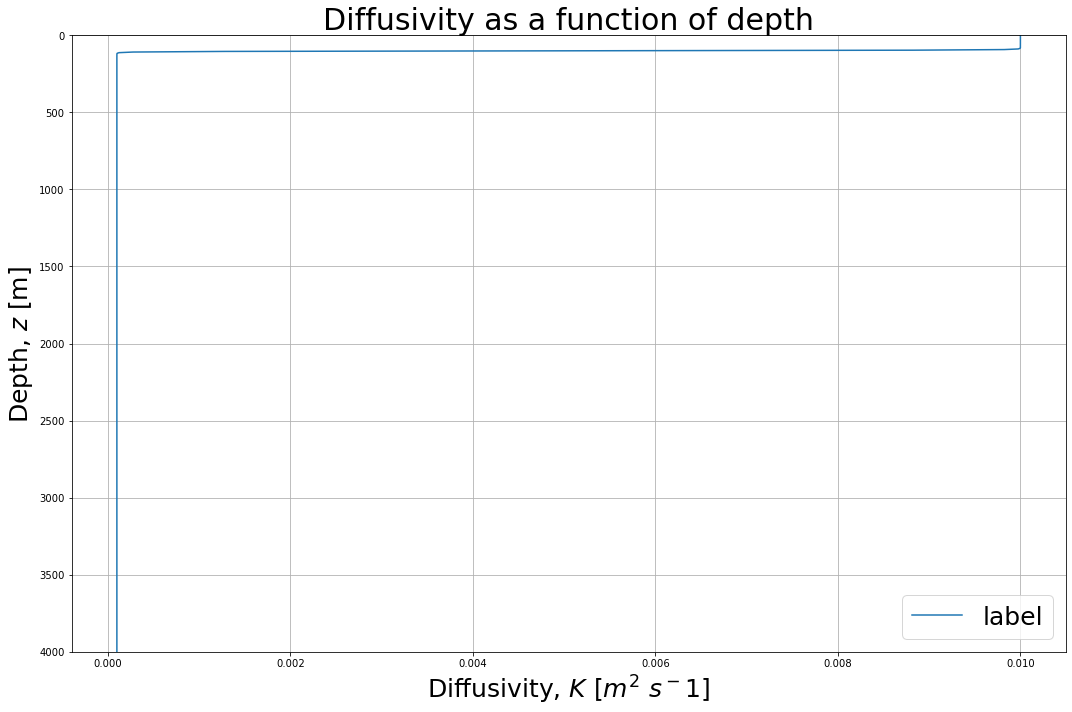

In [21]:
# Makes a figure and sets the size of the figure
plt.figure(3, figsize = [15,10])

#Plots the diffusivity as a function of z
plt.plot(K_deep_lst, z_lst, label = "label")

#Gives us a box in the plot that defines the different functions and sets the size of this box
plt.legend(prop = {'size':25})
# Gives the plot a title and gives the axes titles
plt.title("Diffusivity as a function of depth", fontsize = 30)
plt.xlabel("Diffusivity, $K$ [$m^2$ $s^-1$]", fontsize = 25 )
plt.ylabel("Depth, $z$ [m]", fontsize = 25)
# Sets the span of the y axis
plt.ylim(4000, 0)
# Shows a grid in the plot
plt.grid()
# Makes sure everything fits inside the given size of the plot
plt.tight_layout()
# Makes sure that the plot is shown as an output
plt.show()

As we can see from the plot, the diffusivity is very high the first 100 meters. This high diffusivity explains why the concentration of DIC in the ocean, plotted in task 2b) is more or less "in sync" with the changes in the atmosphere. In contrast, the diffusivity below 100 meters is very low, almost zero. For this reason we expect that the concentration of DIC in the ocean below 100 meters will also be low or more or less zero, just like the plot in task 2b) shows.